## RandomForest and BoostingClassifier :
Objective: 
1. Same as for DT Classifier
2. Take any two hyperparameters and tune them
3. As we are having two hyperparameters to tune for representing the error plot you can
use heat maps,
example like this, rows representing one hyperparameter and columns representing
other hyperparameter and the values in each representing the error metric value.

4. Get important features and represent them in a word cloud.

### Step-By-Step Process 

1. In this, we need to work with all 4-vectorizers (BOW, TFIDF,Avg w2v and TF-IDF weighted w2v) where we will convert our texted review into numerical(vector) form in order to apply any Model on it.

2. As we know our data set is Review of products which besically changes over time so we will first import our table and order our data by time.

3. After that we will take our cleandedtext(i.e cleand text means we have already cleaned our data by removing stops words, other this which are going to affect our model) and then we will split our cleaned test dataset into two parts i.e Train and test with their respective class lables.

4. After doing above points now we need to work on 2 models i.e 

    a. RandomForest
    
    b. GBDT/XGBOOST
    
    Note : As we know XGBOOST is more efficient than GBDT so we will work in XGBOOST as a second model.
    

5. As we know we have two hyperparameters for both the models we will try to tune hyperparameter for both the models by using GridSearchCV which helps us to get optimal i.e best parameter for the models 

6. For both the models we will try to get best hyperparaneters for all 4-vectorizers one by one 

7. lets first start with our first model and then second model i.e 

    a. RandomForest : In this models we will work with two parameters and try to tune it for getting best for both amongest them ans as we know RF is high variance and low bias model so we will try to reduce the variance in the model without impacting the Bias. And as we know our final model is aggregation of (M1,M2,M3,......MK) so as we increase our k i.e the no of The number of trees in the Randomforest i.e parameter called n_estimators, our final model variance will decrease. And second paramater is max_depth: As we know the deeper the tree, the more splits it has and it captures more information about the data. We fit each decision tree with depths ranging from 1 to 34 and plot the training and test errors using GridSearchCV. And as we have two hyperparameters to tune we will plot the results using Heat map. and try to get best parameters 

Note: DT is the base model for RF and  Bias of the RF totally depends upon the no of base_learners i.e n_estimators and so we will try train depth tree and controll the variance using n_estimators i.e no of base learners  
    
    b.GBDT/XGBOOST : We will work on XGBoost because XGBoost is more faster and efficient and GBDT and with XGBOOST we will work with two hyperparameters i.e n_estimators: it represents the number of trees in the forest. Usually the higher the number of trees the better to learn the data. However, adding a lot of trees can slow down the training process considerably, therefore we do a parameter search to find the best. and second is max_depth. This indicates how deep the built tree can be. The deeper the tree, the more splits it has and it captures more information about how the data. We fit a decision tree with depths ranging from 1 to 34 and plot the training and test errors. 
    
8. After doing hyperparameter tuning we will try to get important features and try to get performance using different performance matrix using best hyperparameters. 

9. and we will do above things for our all 4-Vectorizers i.e (BOW, TFIDF,Avg w2v and TF-IDF weighted w2v) on both the models 
      

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
#taking cleaned data i.e in Reviews table  from final sql database
#making connection with database 
conn = sqlite3.connect('final.sqlite') 
final = pd.read_sql_query(""" SELECT * FROM Reviews ORDER BY Time""", conn) 

C:\Users\nisha\Anaconda3\lib\site-packages\gensim\utils.py:1212: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
final = final[:100000]
print(len(final))

100000


In [3]:
CleanedText = final['CleanedText'];
text=final.CleanedText.values
#print(CleanedText)
CleanedText_Class = [];
for i in final['Score']:
    if (i == 'positive'):
        CleanedText_Class.append(1)
    else:
        CleanedText_Class.append(0)
    

In [4]:
# ============================== loading libraries ===========================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
# from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import cross_validation
# ====================================
# split the data set into train and test for BoW
#X_1, X_test, y_1, y_test = cross_validation.train_test_split(X, y, test_size=0.3, random_state=0)
X_tr, X_test, y_tr, y_test = cross_validation.train_test_split(text, CleanedText_Class, test_size=0.3, random_state=0)

# split the train data set into cross validation train and cross validation test
# X_tr, X_cv, y_tr, y_cv = cross_validation.train_test_split(X_1, y_1, test_size=0.3)

C:\Users\nisha\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.model_selection import GridSearchCV
from tqdm import tqdm
import os

from sklearn import tree
import graphviz
import pydotplus
from IPython.display import Image

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from wordcloud import WordCloud
import seaborn as sns; 
def most_informative_feature_for_binary_classification(vectorizer, w,n_features,is_print = True):
#     class_labels = classifier.classes_
    
    feature_names = vectorizer.get_feature_names()
    topn_class = sorted(zip(w, feature_names), reverse=True)[:n_features]
    
    if is_print == True:
        print("\nTop %s features" %(n_features))
        for w, feat in topn_class:
            print(w, feat)
        
    else:
        top_features = []
        for coef, feat in topn_class:
            top_features.append(feat)
            
        return top_features;


def top_features_wordcloud_generated_image_fun(features_list):
    wordcloud = WordCloud(width=600, height=600, margin=0,background_color="white").generate(" ".join(features_list))
    # Display the generated image:
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.margins(x=0, y=0)
    plt.show()

## Bow
Applying Bow vectorizer on data

In [6]:
#BOW 
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=10)
vocabulary= vectorizer.fit(X_tr)
#print("the shape of out text BOW vectorizer ",vocabulary.get_shape())
#bow_x_tr.shape
# bow_tr_array

In [7]:
bow_x_tr= vectorizer.transform(X_tr)
print("the shape of out text BOW vectorizer ",bow_x_tr.get_shape())

the shape of out text BOW vectorizer  (70000, 7155)


## Apply GridSearch Crossvalidation 

#### 1. Random Forest  - Hyperparameter(depth) tuning


In [8]:
parameters = {'max_depth':[2,6,9,12,15,21,27,34], 'n_estimators':[1, 4, 8, 16, 32, 64, 150,250]}

rftuning = GridSearchCV(estimator =RandomForestClassifier(n_jobs=-1,class_weight='balanced'), 
                        param_grid = parameters,cv=3,scoring='f1')
rftuning.fit(bow_x_tr,y_tr)


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 6, 9, 12, 15, 21, 27, 34], 'n_estimators': [1, 4, 8, 16, 32, 64, 150, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

optimal parameters and score is  {'max_depth': 34, 'n_estimators': 150} 0.9461444753957767


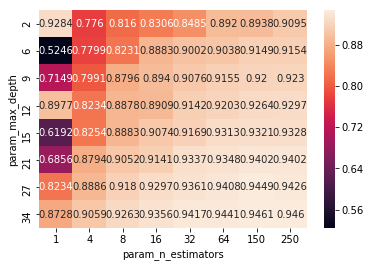

In [11]:
print('optimal parameters and score is ',rftuning.best_params_, rftuning.best_score_)
df_gridsearch = pd.DataFrame(rftuning.cv_results_)
# df_gridsearch
max_scores = df_gridsearch.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [12]:
bow_rf_max_depth =34 
bow_rf_n_estimators = 150

#### 2. XGBoost - Hyperparameter(depth) tuning

In [13]:
import xgboost as xgb
parameters = {'max_depth':[2,6,9,12,15,21,27,34], 'n_estimators':[1, 4, 8, 16, 32, 64, 150,250]}

xgb_model = xgb.XGBClassifier(scale_pos_weight=1)
rs = GridSearchCV(xgb_model,parameters,cv=3,scoring='f1')
rs.fit(bow_x_tr, y_tr)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 6, 9, 12, 15, 21, 27, 34], 'n_estimators': [1, 4, 8, 16, 32, 64, 150, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

optimal parameters and score is  {'max_depth': 27, 'n_estimators': 250} 0.9575700682885673


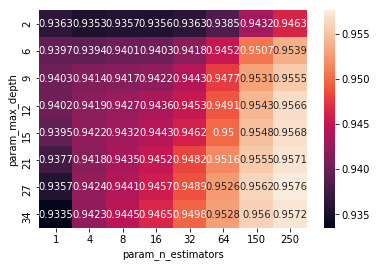

In [14]:
print('optimal parameters and score is ',rs.best_params_, rs.best_score_)
df_gridsearch = pd.DataFrame(rs.cv_results_)
# df_gridsearch
max_scores = df_gridsearch.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [15]:
bow_xgb_opt_n_estimators = 250
bow_xgb_opt_max_depth = 27

## Getting Important Features 

In [16]:
#After getting optimal hyperparameter for both lets print important features 
rf = RandomForestClassifier(n_estimators=bow_rf_n_estimators,max_depth= bow_rf_max_depth, n_jobs=-1,class_weight='balanced')
rf.fit(bow_x_tr, y_tr)
w = rf.feature_importances_

In [17]:
w = rf.feature_importances_
most_informative_feature_for_binary_classification(vectorizer,w,10,is_print = True)


Top 10 features
0.03466511629606206 great
0.022833856834570395 best
0.02107415672450553 love
0.020662915876813168 disappoint
0.015685511427773635 delici
0.012546835669537622 would
0.011050606374655205 perfect
0.010931942426997021 favorit
0.010539084271460311 wast
0.009976481834758234 money


#### Representing Important Features on a word cloud.

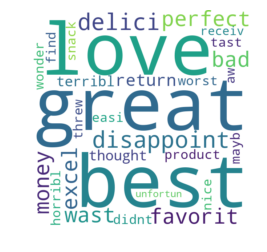

In [18]:
top_features = most_informative_feature_for_binary_classification(vectorizer,w,30,is_print = False)
top_features_wordcloud_generated_image_fun(top_features)

## Performance measure of Test Data on Trained Model with different performance metrix

In [19]:
# vectorizing the test data into Bow for model implimentation 
bow_x_test= vectorizer.transform(X_test)
print("the shape of out text BOW vectorizer ",bow_x_test.get_shape())

the shape of out text BOW vectorizer  (30000, 7155)


#### 1. RandomForestClassifier Performance

In [20]:
rf = RandomForestClassifier(n_estimators=bow_rf_n_estimators,max_depth= bow_rf_max_depth, n_jobs=-1,class_weight='balanced')
rf = rf.fit(bow_x_tr, y_tr)
pred = rf.predict(bow_x_test)

####RandomForestClassifier Performance with optimal n_estimators = 150 and max_depth = 34 ####

The weighted f1_score is 89.779155%

The f1_score is 94.153518%

The recall_score is 94.135579%

The precision_score is 94.171463%

The confusion_matrix
[[ 2228  1529]
 [ 1539 24704]]


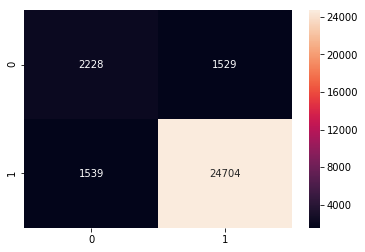

In [21]:
# evaluate weighted f1_score
print("####RandomForestClassifier Performance with optimal n_estimators = %d and max_depth = %d ####"%(bow_rf_n_estimators,bow_rf_max_depth))

sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')



In [22]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n**********CONFUSION MATRIX*********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))

Bow_RandomForestClassifier = [sc,f1_sc,re_sc,pre_sc,TPR,FPR,FNR,TNR]


**********CONFUSION MATRIX*********

****TPR is 94%

****FPR is 40%

****FNR is 5%

****TNR is 59%


### 2. XGBoost Performance 

In [23]:
xgb_model = xgb.XGBClassifier(n_estimators=bow_xgb_opt_n_estimators ,max_depth =bow_xgb_opt_max_depth ).fit(bow_x_tr, y_tr)
pred = xgb_model.predict(bow_x_test)

####XGBoost Performance with optimal n_estimators = 250 and max_depth = 27 ####

The weighted f1_score is 91.262769%

The f1_score is 95.684477%

The recall_score is 98.639637%

The precision_score is 92.901235%

The confusion_matrix
[[ 1779  1978]
 [  357 25886]]


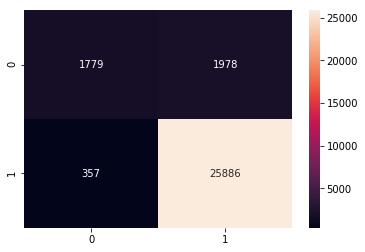

In [24]:
# evaluate weighted f1_score
print("####XGBoost Performance with optimal n_estimators = %d and max_depth = %d ####"%(bow_xgb_opt_n_estimators,bow_xgb_opt_max_depth))
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [25]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n**********CONFUSION MATRIX*********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))
Bow_XGBoost = [sc,f1_sc,re_sc,pre_sc,TPR,FPR,FNR,TNR]



**********CONFUSION MATRIX*********

****TPR is 98%

****FPR is 52%

****FNR is 1%

****TNR is 47%


### Performance Graph for RandomForest and XGBoost -BOW

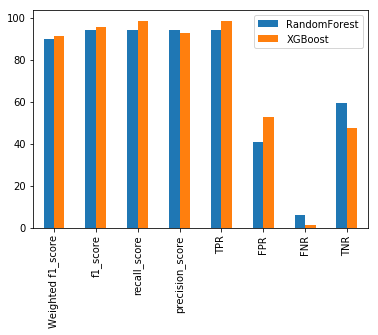

In [26]:
Bow_Performance = pd.DataFrame({'RandomForest':Bow_RandomForestClassifier,'XGBoost':Bow_XGBoost}
                               ,index=['Weighted f1_score','f1_score','recall_score','precision_score','TPR','FPR','FNR','TNR'])
#we can generate bar chart from pandas DataFrame 
# Bow_Performance
Bow_Performance.plot(kind='bar')

*** Bow Ends ****

## TF-IDF

In [27]:
#tfidf 
tf_idf_vect = TfidfVectorizer()
vocabulary = tf_idf_vect.fit(X_tr)
#print("the shape of out text TF-IDF vectorizer ",tf_idf_x_tr.get_shape())

In [28]:
tf_idf_x_tr = tf_idf_vect.transform(X_tr)
print("the shape of out text TF-IDF vectorizer ",tf_idf_x_tr.get_shape())

the shape of out text TF-IDF vectorizer  (70000, 31447)


### Apply GridSearch Crossvalidation
#### 1. Random Forest - Hyperparameter(depth) tuning

In [29]:
parameters = {'max_depth':[2,6,9,12,15,21,27,34], 'n_estimators':[1, 4, 8, 16, 32, 64, 150,250]}

rftuning = GridSearchCV(estimator = RandomForestClassifier(n_jobs=-1,class_weight='balanced'),
                        param_grid = parameters,cv=3,scoring='f1')
rftuning.fit(tf_idf_x_tr,y_tr)



GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 6, 9, 12, 15, 21, 27, 34], 'n_estimators': [1, 4, 8, 16, 32, 64, 150, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

optimal parameters and score is  {'max_depth': 34, 'n_estimators': 250} 0.9527458147492451


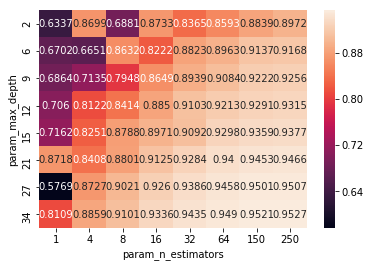

In [30]:
print('optimal parameters and score is ',rftuning.best_params_, rftuning.best_score_)
df_gridsearch = pd.DataFrame(rftuning.cv_results_)
# df_gridsearch
max_scores = df_gridsearch.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [31]:
rf_tfidf_max_depth = 34 
rf_tfidf_n_estimators = 250

#### 2. XGBoost - Hyperparameter(depth) tuning

In [32]:
import xgboost as xgb
parameters = {'max_depth':[2,6,9,12,15,21,27,34], 'n_estimators':[1, 4, 8, 16, 32, 64, 150,250]}

xgb_model = xgb.XGBClassifier(scale_pos_weight=1)

rs = GridSearchCV(xgb_model,parameters,cv=3,scoring='f1')
rs.fit(tf_idf_x_tr, y_tr)
# best_est = rs.best_estimator_
# print(best_est)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 6, 9, 12, 15, 21, 27, 34], 'n_estimators': [1, 4, 8, 16, 32, 64, 150, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

optimal parameters and score is  {'max_depth': 15, 'n_estimators': 250} 0.9560569342610601


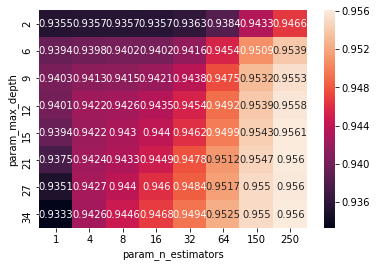

In [33]:
print('optimal parameters and score is ',rs.best_params_, rs.best_score_)
df_gridsearch = pd.DataFrame(rs.cv_results_)
# df_gridsearch
max_scores = df_gridsearch.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [34]:
tfidf_xgb_opt_n_estimators = 250
tfidf_xgb_opt_max_depth = 15

## Getting Important Features

In [35]:
#After getting optimal hyperparameter for both lets print important features 
rf = RandomForestClassifier(n_estimators=rf_tfidf_n_estimators,max_depth= rf_tfidf_max_depth, n_jobs=-1,class_weight='balanced')
rf.fit(tf_idf_x_tr, y_tr)
w = rf.feature_importances_

In [36]:
w = rf.feature_importances_
most_informative_feature_for_binary_classification(tf_idf_vect,w,10,is_print = True)


Top 10 features
0.029365774628524403 great
0.025177462198403777 love
0.019942041173115127 best
0.018960829140175755 disappoint
0.012895227971350917 delici
0.009870938063323958 money
0.00969031477806908 would
0.008755755569081997 favorit
0.008492289788240948 easi
0.007922143349342154 perfect


### Representing Important Features on a word cloud.

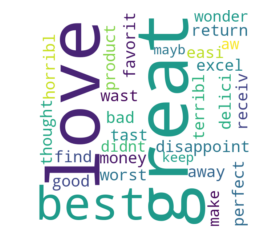

In [37]:
top_features = most_informative_feature_for_binary_classification(tf_idf_vect,w,30,is_print = False)
top_features_wordcloud_generated_image_fun(top_features)

## Performance measure of Test Data on Trained Model with different performance metrix

In [38]:
tf_idf_x_test= tf_idf_vect.transform(X_test)
print("the shape of out text TF-IDF vectorizer ",tf_idf_x_test.get_shape())

the shape of out text TF-IDF vectorizer  (30000, 31447)


#### 1. RandomForestClassifier Performance

In [39]:
rf = RandomForestClassifier(n_estimators=rf_tfidf_n_estimators,
                            max_depth= rf_tfidf_max_depth, n_jobs=-1,class_weight='balanced')
rf = rf.fit(tf_idf_x_tr, y_tr)
pred = rf.predict(tf_idf_x_test)

####RandomForestClassifier Performance with optimal n_estimators = 250 and max_depth = 34 ####

The weighted f1_score is 90.895864%

The f1_score is 94.998301%

The recall_score is 95.896048%

The precision_score is 94.117207%

The confusion_matrix
[[ 2184  1573]
 [ 1077 25166]]


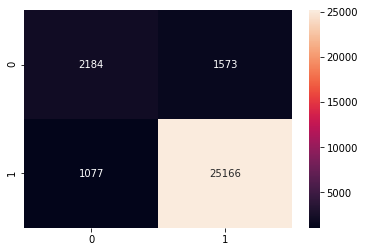

In [40]:
# evaluate weighted f1_score
print("####RandomForestClassifier Performance with optimal n_estimators = %d and max_depth = %d ####"
      %(rf_tfidf_n_estimators,rf_tfidf_max_depth))
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [41]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n**********CONFUSION MATRIX*********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))

tfidf_RandomForestClassifier = [sc,f1_sc,re_sc,pre_sc,TPR,FPR,FNR,TNR]


**********CONFUSION MATRIX*********

****TPR is 95%

****FPR is 41%

****FNR is 4%

****TNR is 58%


### 2. XGBoost Perormance

In [42]:
xgb_model = xgb.XGBClassifier(n_estimators=tfidf_xgb_opt_n_estimators ,
                              max_depth =tfidf_xgb_opt_max_depth ).fit(tf_idf_x_tr, y_tr)
pred = xgb_model.predict(tf_idf_x_test)

####XGBoost Performance with optimal n_estimators = 250 and max_depth = 15 ####

The weighted f1_score is 90.911985%

The f1_score is 95.550758%

The recall_score is 98.651069%

The precision_score is 92.639376%

The confusion_matrix
[[ 1700  2057]
 [  354 25889]]


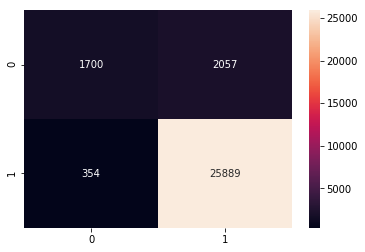

In [43]:
# evaluate weighted f1_score
print("####XGBoost Performance with optimal n_estimators = %d and max_depth = %d ####"
      %(tfidf_xgb_opt_n_estimators,tfidf_xgb_opt_max_depth))
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [44]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n**********CONFUSION MATRIX*********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))
tfidf_XGBoost = [sc,f1_sc,re_sc,pre_sc,TPR,FPR,FNR,TNR]



**********CONFUSION MATRIX*********

****TPR is 98%

****FPR is 54%

****FNR is 1%

****TNR is 45%


### Performance Graph of RandomForest and XGBoost - TF-IDF

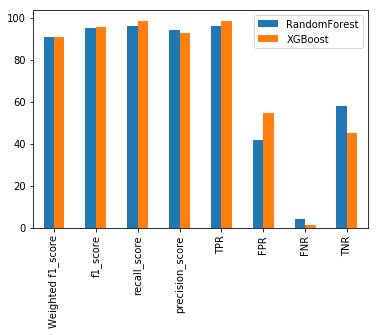

In [45]:
tfidf_Performance = pd.DataFrame({'RandomForest':tfidf_RandomForestClassifier,'XGBoost':tfidf_XGBoost}
                               ,index=['Weighted f1_score','f1_score','recall_score','precision_score','TPR','FPR','FNR','TNR'])
#we can generate bar chart from pandas DataFrame 
# tfidf_Performance
tfidf_Performance.plot(kind='bar')

***** TF-IDF ENDS ******

## Word2Vec

In [46]:
#Word2Vec mode 
#spliting train sentence in words 
# Train your own Word2Vec model using your own text corpus
i=0
X_tr_list_of_sent=[]
for sent in X_tr:
    X_tr_list_of_sent.append(sent.split())
    
print(len(X_tr))
# print("\n--------------Spliting each sentence into words--------word list of ie data corpus---------\n")
# print(X_tr_list_of_sent[:2])
#word list of ie data corpus

70000


In [47]:
#The Word to Vec model produces a vocabulary, with each word being represented by 
#an n-dimensional numpy array 
X_tr_w2v_model=Word2Vec(X_tr_list_of_sent,min_count=1,size=50, workers=4)
X_tr_w2v_model.wv['man']
wlist =list(X_tr_w2v_model.wv.vocab)
# wlist is a list of words 
len(wlist)

31447

#### Train for Avgword2vec

In [48]:
#CALCULATE AVG WORD2VEC FOR x_tr
w2v_words = list(X_tr_w2v_model.wv.vocab)
# compute average word2vec for each review.
X_tr_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_tr_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_tr_sent_vectors.append(sent_vec)
print(len(X_tr_sent_vectors))
print(len(X_tr_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [02:31<00:00, 463.38it/s]


70000
50


#### Test for Avgword2vec

In [49]:
#Train your own Word2Vec model using your own text corpus
#spliting test sentence in words 
i=0
X_test_list_of_sent=[]
for sent in X_test:
    X_test_list_of_sent.append(sent.split())
    
print(len(X_test_list_of_sent))

30000


In [50]:
#CALCULATE AVG WORD2VEC FOR x_test
# w2v_words = list(X_test_w2v_model.wv.vocab)

w2v_words = list(X_tr_w2v_model.wv.vocab)

# compute average word2vec for each review.
X_test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_test_list_of_sent): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
#             vec = X_test_w2v_model.wv[word]
            vec = X_tr_w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_sent_vectors.append(sent_vec)
print(len(X_test_sent_vectors))
print(len(X_test_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:08<00:00, 440.68it/s]


30000
50


### Apply GridSearch Crossvalidation
#### 1. Random Forest - Hyperparameter(depth) tuning

In [51]:
parameters = {'max_depth':[2,6,9,12,15,21,27,34], 'n_estimators':[1, 4, 8, 16, 32, 64, 150,250]}

rftuning = GridSearchCV(estimator = RandomForestClassifier(n_jobs=-1,class_weight='balanced'), 
                        param_grid = parameters,cv=3,scoring='f1')
rftuning.fit(X_tr_sent_vectors,y_tr)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 6, 9, 12, 15, 21, 27, 34], 'n_estimators': [1, 4, 8, 16, 32, 64, 150, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

optimal parameters and score is  {'max_depth': 21, 'n_estimators': 150} 0.9437671251219227


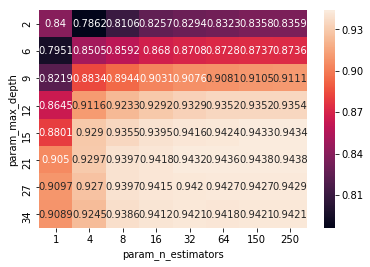

In [52]:
print('optimal parameters and score is ',rftuning.best_params_, rftuning.best_score_)
df_gridsearch = pd.DataFrame(rftuning.cv_results_)
# df_gridsearch
max_scores = df_gridsearch.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [53]:
rf_avgw2v_max_depth = 21 
rf_avgw2v_n_estimators = 150

#### 2. XGBoost - Hyperparameter(depth) tuning

In [54]:
import xgboost as xgb
parameters = {'max_depth':[2,6,9,12,15,21,27,34], 'n_estimators':[1, 4, 8, 16, 32, 64, 150,250]}

xgb_model = xgb.XGBClassifier(scale_pos_weight=1)

rs = GridSearchCV(xgb_model,parameters,cv=3,scoring='f1')
rs.fit(np.array(X_tr_sent_vectors), y_tr)
# best_est = rs.best_estimator_
# print(best_est)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 6, 9, 12, 15, 21, 27, 34], 'n_estimators': [1, 4, 8, 16, 32, 64, 150, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

optimal parameters and score is  {'max_depth': 12, 'n_estimators': 250} 0.9498647564087533


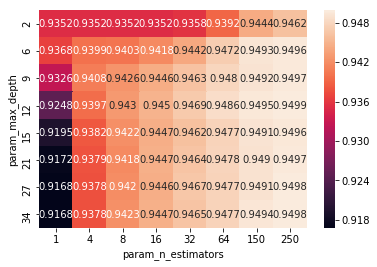

In [55]:
print('optimal parameters and score is ',rs.best_params_, rs.best_score_)
df_gridsearch = pd.DataFrame(rs.cv_results_)
# df_gridsearch
max_scores = df_gridsearch.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [56]:
xgb_avgw2v_max_depth = 12 
xgb_avgw2v_n_estimators = 250

### Performance measure of Test Data on Trained Model with different performance metrix
#### 1. RandomForestClassifier Performance

####RandomForestClassifier Performance with optimal n_estimators = 150 and max_depth = 21 ####

The weighted f1_score is 87.277862%

The f1_score is 94.215298%

The recall_score is 98.399573%

The precision_score is 90.372366%

The confusion_matrix
[[ 1006  2751]
 [  420 25823]]


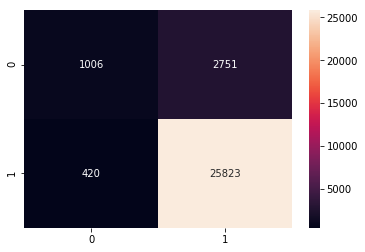

In [57]:
rf = RandomForestClassifier(n_estimators=rf_avgw2v_n_estimators,
                            max_depth= rf_avgw2v_max_depth, n_jobs=-1,class_weight='balanced')
rf = rf.fit(X_tr_sent_vectors, y_tr)
pred = rf.predict(X_test_sent_vectors)

# evaluate weighted f1_score
print("####RandomForestClassifier Performance with optimal n_estimators = %d and max_depth = %d ####"
      %(rf_avgw2v_n_estimators,rf_avgw2v_max_depth))
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [58]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n**********CONFUSION MATRIX*********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))

avgw2v_RandomForestClassifier = [sc,f1_sc,re_sc,pre_sc,TPR,FPR,FNR,TNR]


**********CONFUSION MATRIX*********

****TPR is 98%

****FPR is 73%

****FNR is 1%

****TNR is 26%


### 2. XGBoost Perormance

####XGBoost Performance with optimal n_estimators = 250 and max_depth = 12 ####

The weighted f1_score is 89.302744%

The f1_score is 94.862125%

The recall_score is 98.250962%

The precision_score is 91.699267%

The confusion_matrix
[[ 1423  2334]
 [  459 25784]]


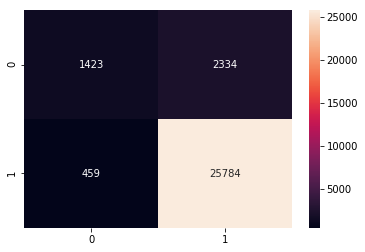

In [59]:
xgb_model = xgb.XGBClassifier(n_estimators=xgb_avgw2v_n_estimators ,
                              max_depth =xgb_avgw2v_max_depth ).fit(np.array(X_tr_sent_vectors), y_tr)
pred = xgb_model.predict(np.array(X_test_sent_vectors))

# evaluate weighted f1_score
print("####XGBoost Performance with optimal n_estimators = %d and max_depth = %d ####"
      %(xgb_avgw2v_n_estimators,xgb_avgw2v_max_depth))
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [60]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n**********CONFUSION MATRIX*********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))
avgw2v_XGBoost = [sc,f1_sc,re_sc,pre_sc,TPR,FPR,FNR,TNR]



**********CONFUSION MATRIX*********

****TPR is 98%

****FPR is 62%

****FNR is 1%

****TNR is 37%


### Performance Graph of RandomForest and XGBoost - AVG-W2V

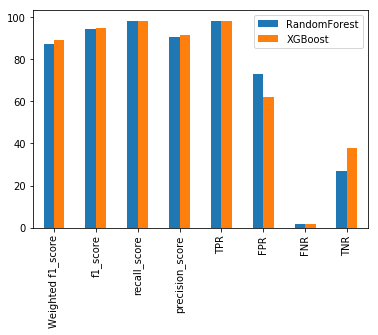

In [61]:
avgw2v_Performance = pd.DataFrame({'RandomForest':avgw2v_RandomForestClassifier,'XGBoost':avgw2v_XGBoost}
                               ,index=['Weighted f1_score','f1_score','recall_score','precision_score','TPR','FPR','FNR','TNR'])
#we can generate bar chart from pandas DataFrame 
# tfidf_Performance
avgw2v_Performance.plot(kind ='bar')

******AVG-W2V ENDS ****

## TF-IDF weighted Word2Vec

In [62]:
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tf_idf_vect.get_feature_names(), list(tf_idf_vect.idf_)))

In [63]:
# TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_tr_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_tr_list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_tr_tfidf_sent_vectors.append(sent_vec)
    row += 1

print(len(X_tr_tfidf_sent_vectors))
print(len(X_tr_tfidf_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 70000/70000 [06:31<00:00, 178.95it/s]


70000
50


In [64]:
#--new way TF-IDF weighted Word2Vec for cv with train data 
   # TF-IDF weighted Word2Vec
tfidf_feat = tf_idf_vect.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_test_list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = X_tr_w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_sent_vectors.append(sent_vec)
    row += 1

#--------------------------------------------------new way
print(len(X_test_tfidf_sent_vectors))
print(len(X_test_tfidf_sent_vectors[0]))

100%|███████████████████████████████████████████████████████████████████████████| 30000/30000 [01:37<00:00, 308.48it/s]


30000
50


### Apply GridSearch Crossvalidation
#### 1. Random Forest - Hyperparameter(depth) tuning

In [65]:
parameters = {'max_depth':[2,6,9,12,15,21,27,34], 'n_estimators':[1, 4, 8, 16, 32, 64, 150,250]}

rftuning = GridSearchCV(estimator = RandomForestClassifier(n_jobs=-1,class_weight='balanced'),
                        param_grid = parameters,cv=3,scoring='f1')
rftuning.fit(X_tr_tfidf_sent_vectors,y_tr)


GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 6, 9, 12, 15, 21, 27, 34], 'n_estimators': [1, 4, 8, 16, 32, 64, 150, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

optimal parameters and score is  {'max_depth': 21, 'n_estimators': 250} 0.9419141096960009


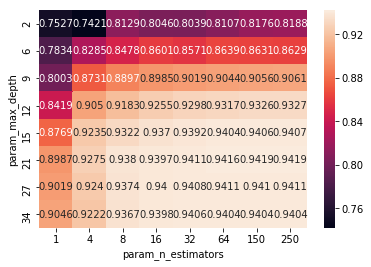

In [66]:
print('optimal parameters and score is ',rftuning.best_params_, rftuning.best_score_)
df_gridsearch = pd.DataFrame(rftuning.cv_results_)
# df_gridsearch
max_scores = df_gridsearch.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [67]:
rf_tfidf_w2v_max_depth = 21
rf_tfidf_w2v_n_estimators = 250

#### 2. XGBoost - Hyperparameter(depth) tuning

In [68]:
import xgboost as xgb
parameters = {'max_depth':[2,6,9,12,15,21,27,34], 'n_estimators':[1, 4, 8, 16, 32, 64, 150,250]}

xgb_model = xgb.XGBClassifier(scale_pos_weight=1)
 
rs = GridSearchCV(xgb_model,parameters,cv=3,scoring='f1')
rs.fit(np.array(X_tr_tfidf_sent_vectors), y_tr)
# best_est = rs.best_estimator_
# print(best_est)

GridSearchCV(cv=3, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [2, 6, 9, 12, 15, 21, 27, 34], 'n_estimators': [1, 4, 8, 16, 32, 64, 150, 250]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1', verbose=0)

optimal parameters and score is {'max_depth': 15, 'n_estimators': 250} 0.9463430909175375


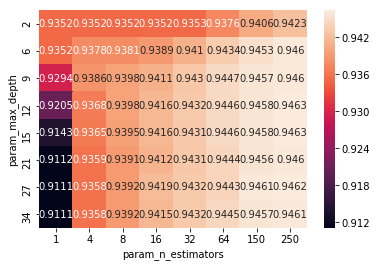

In [69]:
print('optimal parameters and score is',rs.best_params_, rs.best_score_)
df_gridsearch = pd.DataFrame(rs.cv_results_)
# df_gridsearch
max_scores = df_gridsearch.groupby(['param_max_depth', 
                                    'param_n_estimators']).max()
max_scores = max_scores.unstack()[['mean_test_score', 'mean_train_score']]
sns.heatmap(max_scores.mean_test_score, annot=True, fmt='.4g');

In [70]:
xgb_tfidf_w2v_max_depth = 15
xgb_tfidf_w2v_n_estimators = 250

### Performance measure of Test Data on Trained Model with optimal value of max_depth different performance metrix

#### 1. RandomForestClassifier Performance

####RandomForestClassifier Performance with optimal n_estimators = 250 and max_depth = 21 ####

The weighted f1_score is 86.483234%

The f1_score is 94.063181%

The recall_score is 98.712037%

The precision_score is 89.832507%

The confusion_matrix
[[  825  2932]
 [  338 25905]]


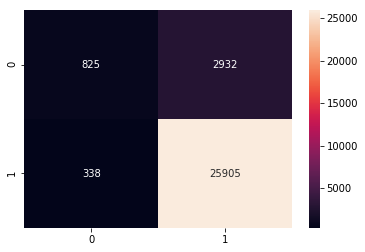

In [71]:
rf = RandomForestClassifier(n_estimators=rf_tfidf_w2v_n_estimators,
                            max_depth= rf_tfidf_w2v_max_depth, n_jobs=-1,class_weight='balanced')
rf = rf.fit(X_tr_tfidf_sent_vectors, y_tr)
pred = rf.predict(X_test_tfidf_sent_vectors)

# evaluate weighted f1_score
print("####RandomForestClassifier Performance with optimal n_estimators = %d and max_depth = %d ####"
      %(rf_tfidf_w2v_n_estimators,rf_tfidf_w2v_max_depth))
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [72]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n**********CONFUSION MATRIX*********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))

tfidfw2v_RandomForestClassifier = [sc,f1_sc,re_sc,pre_sc,TPR,FPR,FNR,TNR]


**********CONFUSION MATRIX*********

****TPR is 98%

****FPR is 78%

****FNR is 1%

****TNR is 21%


### 2. XGBoost Perormance

####XGBoost Performance with optimal n_estimators = 250 and max_depth = 12 ####

The weighted f1_score is 88.065014%

The f1_score is 94.542932%

The recall_score is 98.662500%

The precision_score is 90.753593%

The confusion_matrix
[[ 1119  2638]
 [  351 25892]]


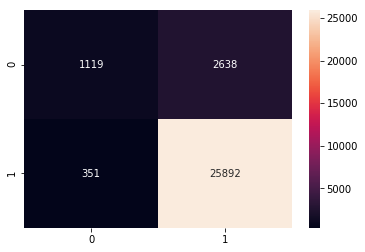

In [73]:
xgb_model = xgb.XGBClassifier(n_estimators=xgb_tfidf_w2v_n_estimators ,
                              max_depth = xgb_tfidf_w2v_max_depth).fit(np.array(X_tr_tfidf_sent_vectors), y_tr)
pred = xgb_model.predict(np.array(X_test_tfidf_sent_vectors))

# evaluate weighted f1_score
print("####XGBoost Performance with optimal n_estimators = %d and max_depth = %d ####"
      %(xgb_avgw2v_n_estimators,xgb_avgw2v_max_depth))
sc = f1_score(y_test, pred,average="weighted") * 100
print('\nThe weighted f1_score is %f%%' % (sc))

# evaluate f1_score
f1_sc = f1_score(y_test, pred) * 100
print('\nThe f1_score is %f%%' % (f1_sc))

# evaluate recall_score
re_sc = recall_score(y_test, pred) * 100
print('\nThe recall_score is %f%%' % (re_sc))

# evaluate precision_score
pre_sc = precision_score(y_test, pred) * 100
print('\nThe precision_score is %f%%' % (pre_sc))

# evaluate confusion matrix score
confusion_matrix_val = confusion_matrix(y_test, pred)
print('\nThe confusion_matrix')
print(confusion_matrix_val);

cunfusion_lable = confusion_matrix_val
ax = sns.heatmap(confusion_matrix_val,annot=cunfusion_lable, fmt='')

In [74]:
tn, fp, fn, tp = confusion_matrix(y_test, pred).ravel() 

TPR = ((tp)/(fn+tp)) * float(100);
FPR = (fp)/(tn+fp) * float(100);
FNR = (fn)/(fn+tp) * float(100);
TNR = (tn)/(tn+fp) * float(100)
print('\n**********CONFUSION MATRIX*********')
print('\n****TPR is %d%%' % (TPR))
print('\n****FPR is %d%%' % (FPR))
print('\n****FNR is %d%%' % (FNR))
print('\n****TNR is %d%%' % (TNR))
tfidfw2v_XGBoost = [sc,f1_sc,re_sc,pre_sc,TPR,FPR,FNR,TNR]



**********CONFUSION MATRIX*********

****TPR is 98%

****FPR is 70%

****FNR is 1%

****TNR is 29%


### Performance Graph of RandomForest and XGBoost - TF-IDF W2V

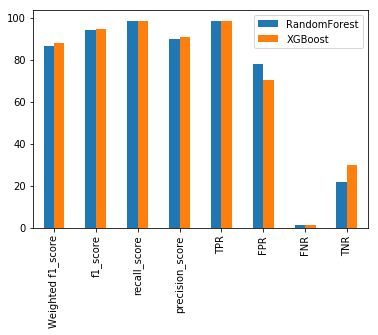

In [75]:
tfidfw2v_Performance = pd.DataFrame({'RandomForest':tfidfw2v_RandomForestClassifier,'XGBoost':tfidfw2v_XGBoost}
                               ,index=['Weighted f1_score','f1_score','recall_score','precision_score','TPR','FPR','FNR','TNR'])
#we can generate bar chart from pandas DataFrame 
# tfidfw2v_Performance
tfidfw2v_Performance.plot(kind ='bar')

******** TF-IDF W2V ENDS *******

## Conclusion

In [3]:
from prettytable import PrettyTable
print('RandomForestClassifier Performance Table')
x = PrettyTable()
x.field_names =["Vectorizer","Model","WeightedF1","F1","Recall","precision","TPR","FPR","FNR","TNR"]

x.add_row(["BOW","RF",89.77, 94.17, 94.12, 94.22, 94, 40, 5, 59])
x.add_row(["TF-IDF","RF",90.07, 94.99, 95.95, 94.11, 95, 41, 4, 58])
x.add_row(["AVG W2V","RF",87.27, 94.21, 98.39, 90.37, 98, 73, 1, 26])
x.add_row(["TF-IDF W2v","RF",86.64, 94.08, 98.61, 89.94, 98, 78, 1, 21])
print(x)

print("\n XGBoost Performance Table ")
y = PrettyTable()
y.field_names =["Vectorizer","Model" , "WeightedF1","F1","Recall","precision","TPR","FPR","FNR","TNR"]
y.add_row(["BOW","XGB",91.26, 95.68, 98.63, 92.90, 98, 52, 1, 47])
y.add_row(["TF-IDF","XGB",90.91, 95.55, 98.65, 92.63, 98, 54, 1, 45])
y.add_row(["AVG W2V","XGB",89.25, 94.87, 98.37, 91.61, 98, 62, 1, 37])
y.add_row(["TF-IDF W2v","XGB",88.57, 94.64, 98.41, 91.15, 98, 70, 1, 29])
print(y)

RandomForestClassifier Performance Table
+------------+-------+------------+-------+--------+-----------+-----+-----+-----+-----+
| Vectorizer | Model | WeightedF1 |   F1  | Recall | precision | TPR | FPR | FNR | TNR |
+------------+-------+------------+-------+--------+-----------+-----+-----+-----+-----+
|    BOW     |   RF  |   89.77    | 94.17 | 94.12  |   94.22   |  94 |  40 |  5  |  59 |
|   TF-IDF   |   RF  |   90.07    | 94.99 | 95.95  |   94.11   |  95 |  41 |  4  |  58 |
|  AVG W2V   |   RF  |   87.27    | 94.21 | 98.39  |   90.37   |  98 |  73 |  1  |  26 |
| TF-IDF W2v |   RF  |   86.64    | 94.08 | 98.61  |   89.94   |  98 |  78 |  1  |  21 |
+------------+-------+------------+-------+--------+-----------+-----+-----+-----+-----+

 XGBoost Performance Table 
+------------+-------+------------+-------+--------+-----------+-----+-----+-----+-----+
| Vectorizer | Model | WeightedF1 |   F1  | Recall | precision | TPR | FPR | FNR | TNR |
+------------+-------+------------+-----